IMPORT ALL NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, precision_recall_curve

from xgboost import XGBClassifier

import joblib
import warnings
import os

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("All libraries imported successfully!")

All libraries imported successfully!


LOAD THE RAW DATASET

In [40]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Original dataset shape:", df.shape)
df.head(3)

Original dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [41]:
# Step 3.1: Convert TotalCharges to numeric (has spaces/blanks → NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [42]:
# Step 3.2: Drop rows with missing TotalCharges (only 11 rows → 0.16%)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

In [43]:
# Step 3.3: Remove useless column (no predictive power)
df = df.drop('customerID', axis=1)
print("Shape after cleaning:", df.shape)
print("Missing values now:\n", df.isnull().sum())

Shape after cleaning: (7032, 20)
Missing values now:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


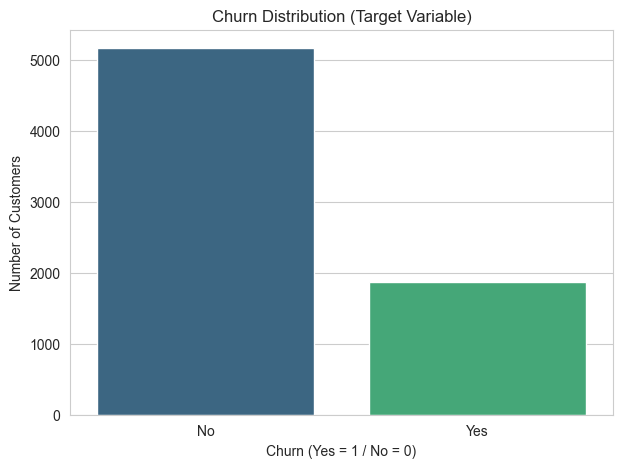

Churn percentage:
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [44]:
# 4 TARGET VARIABLE ANALYSIS
plt.figure(figsize=(7,5))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Churn Distribution (Target Variable)')
plt.xlabel('Churn (Yes = 1 / No = 0)')
plt.ylabel('Number of Customers')
plt.show()

print("Churn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Explanation:
# We have ~73% No churn vs ~27% Yes churn → CLASS IMBALANCE
# This is normal in churn prediction → we will use AUC as main metric (not accuracy)

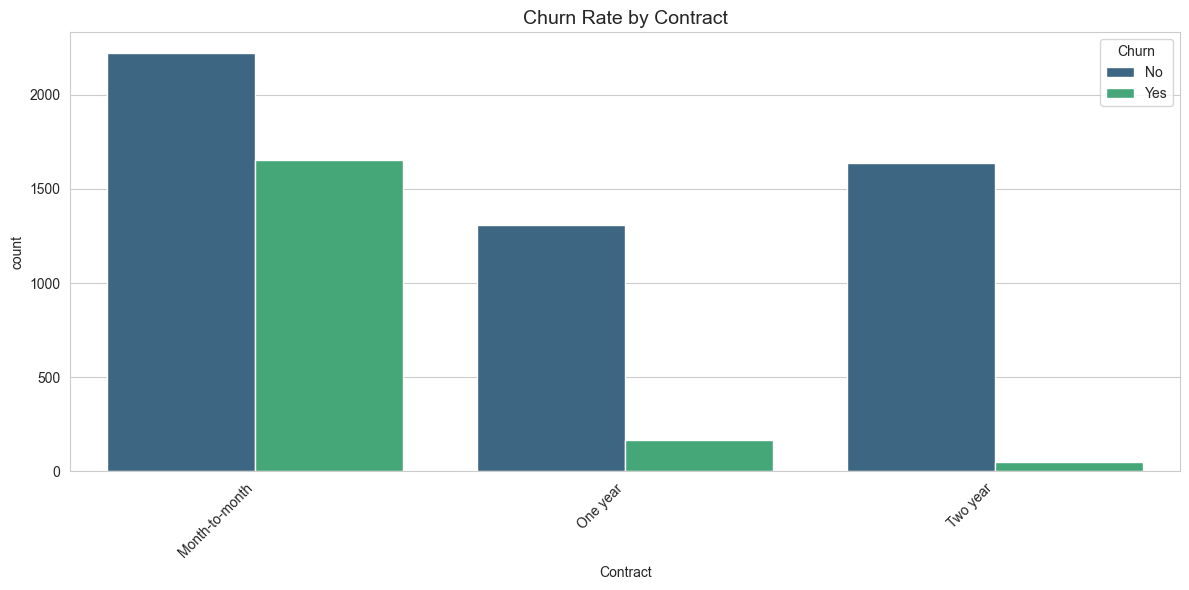

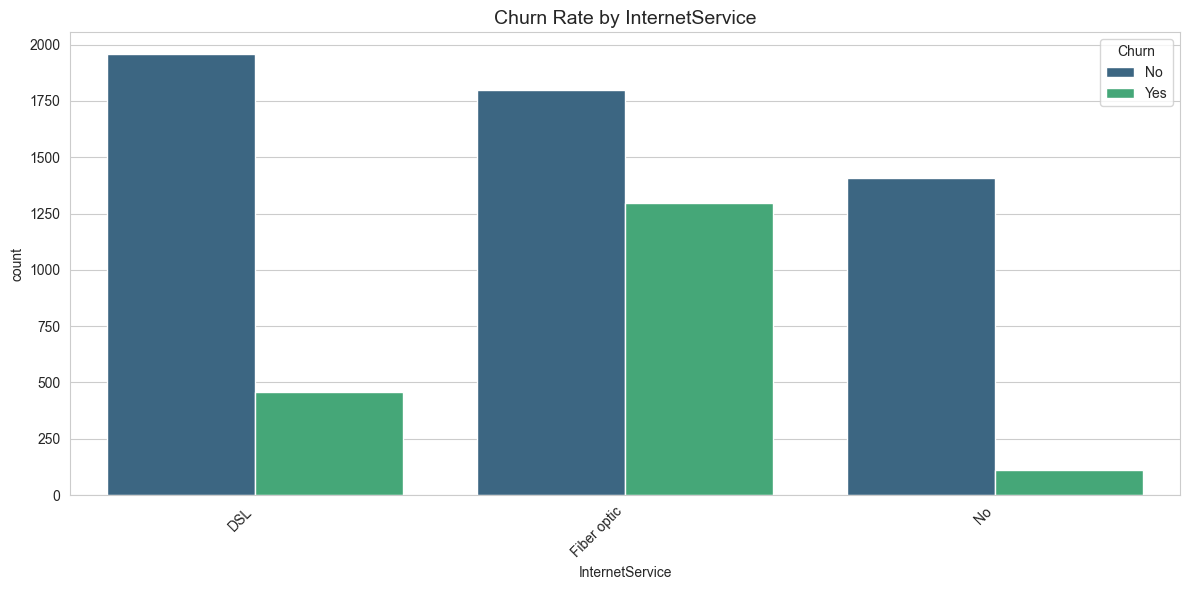

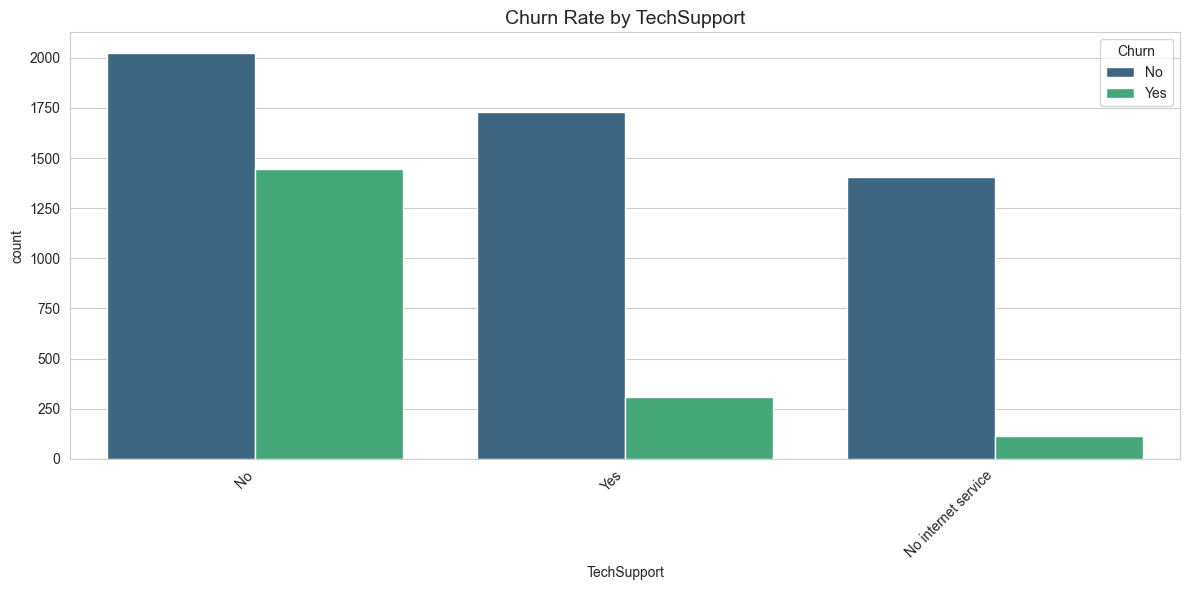

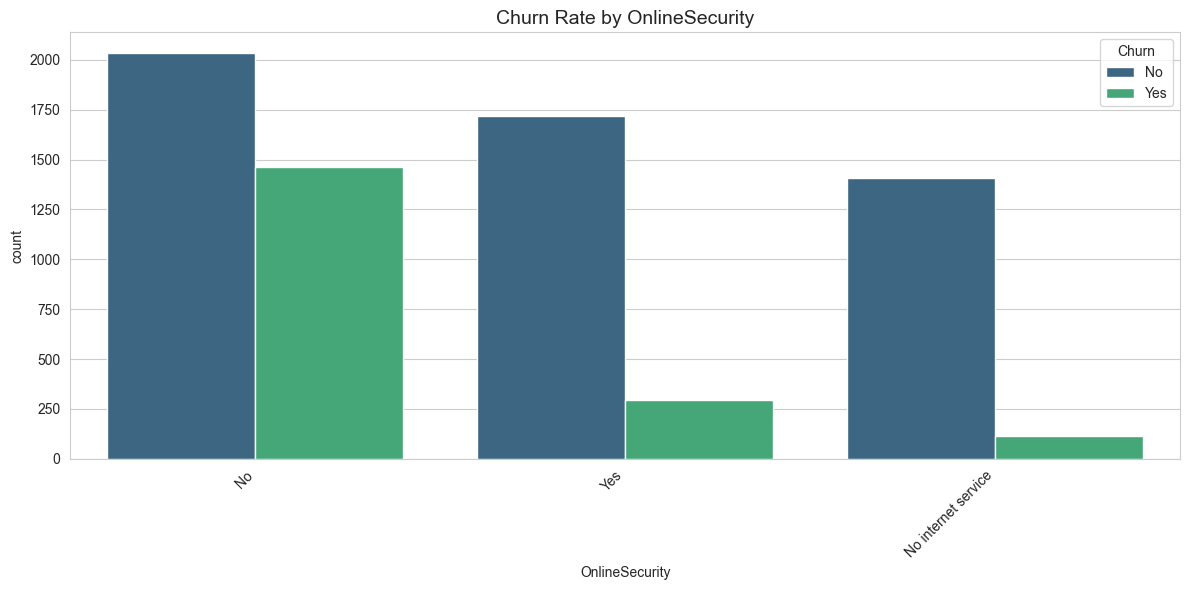

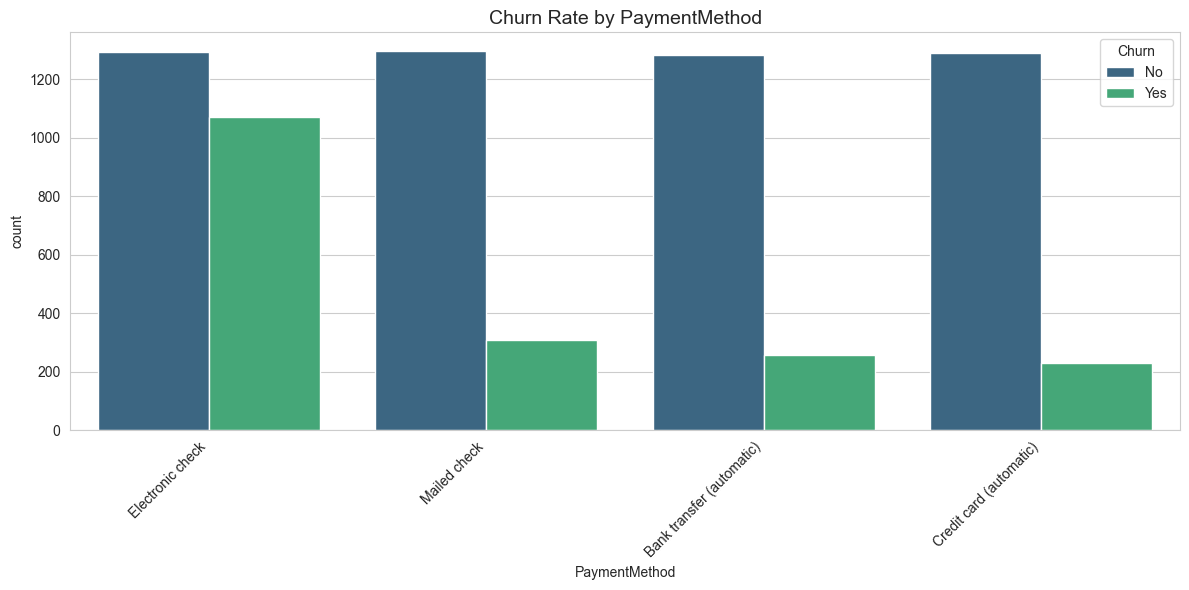

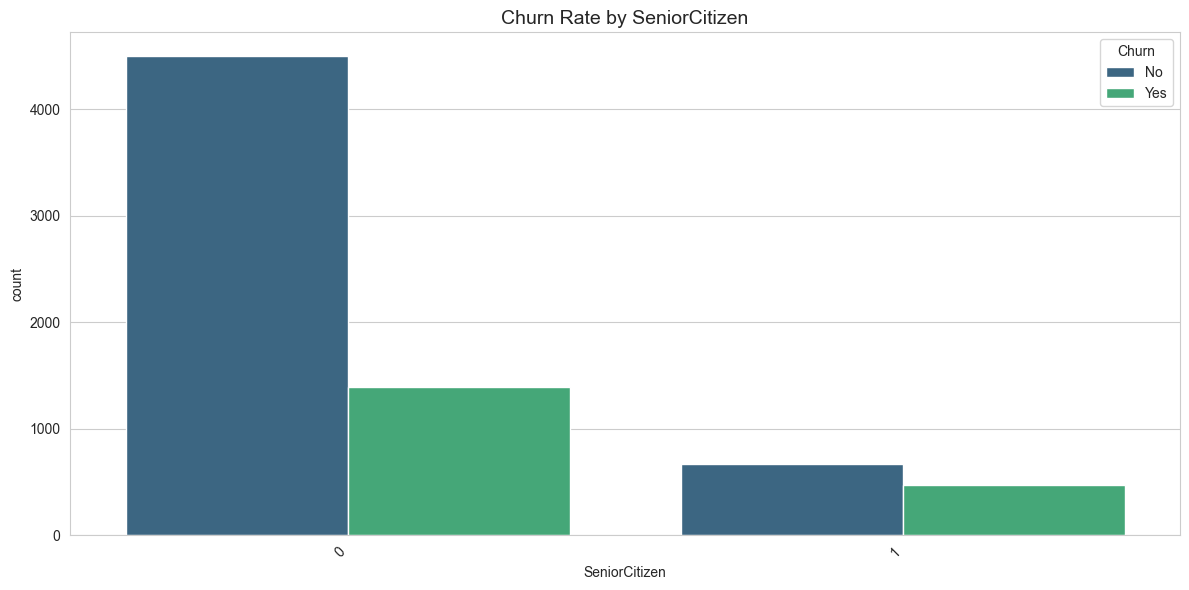

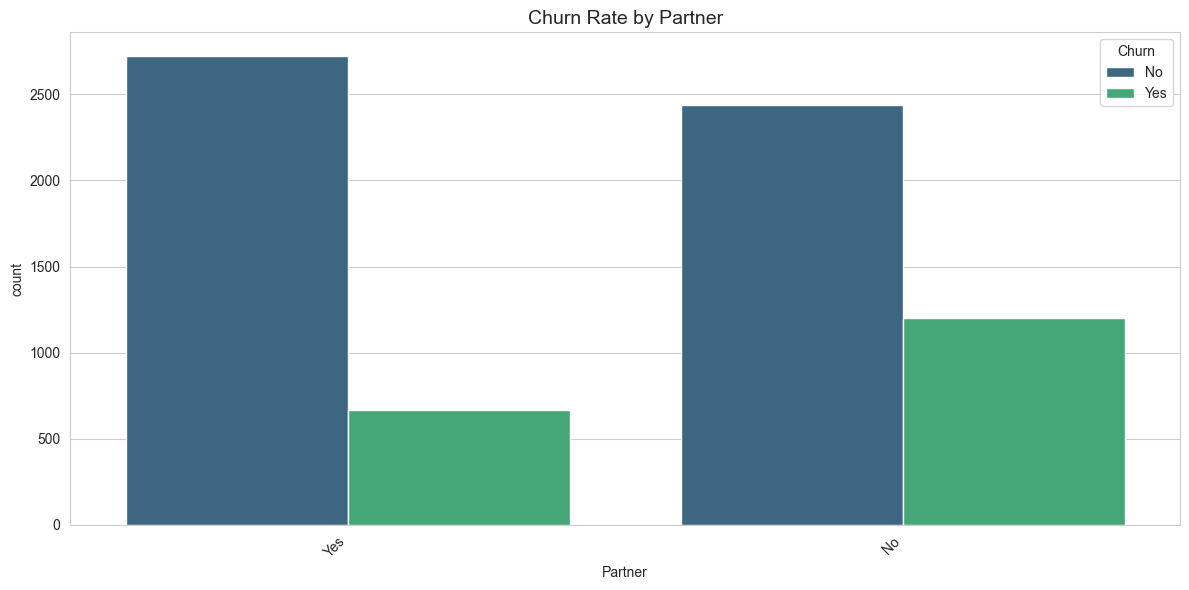

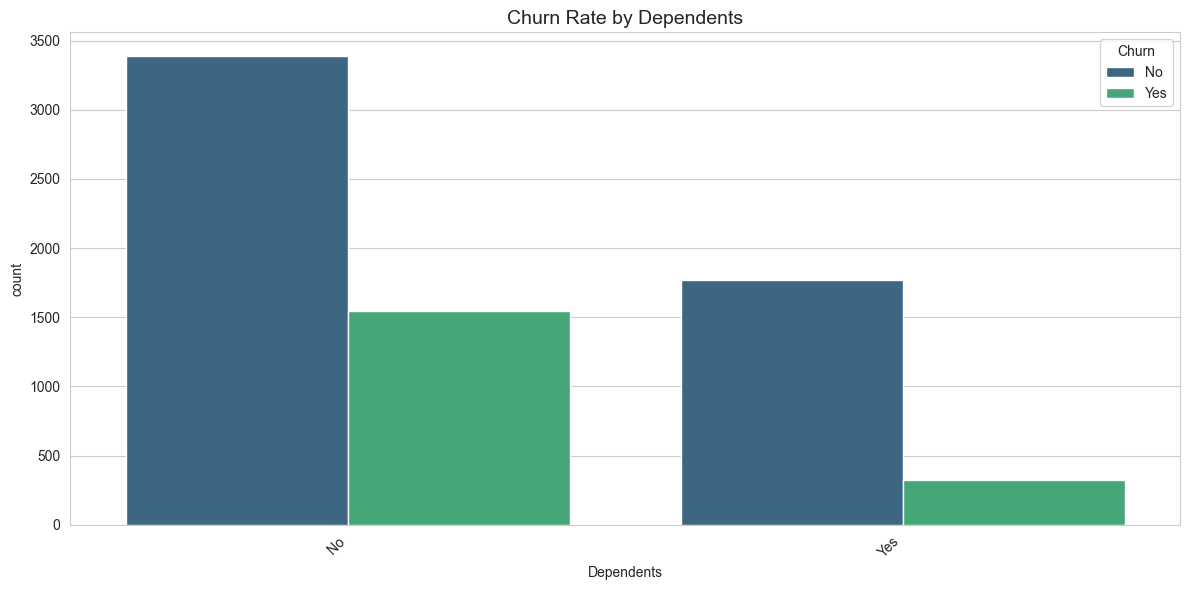

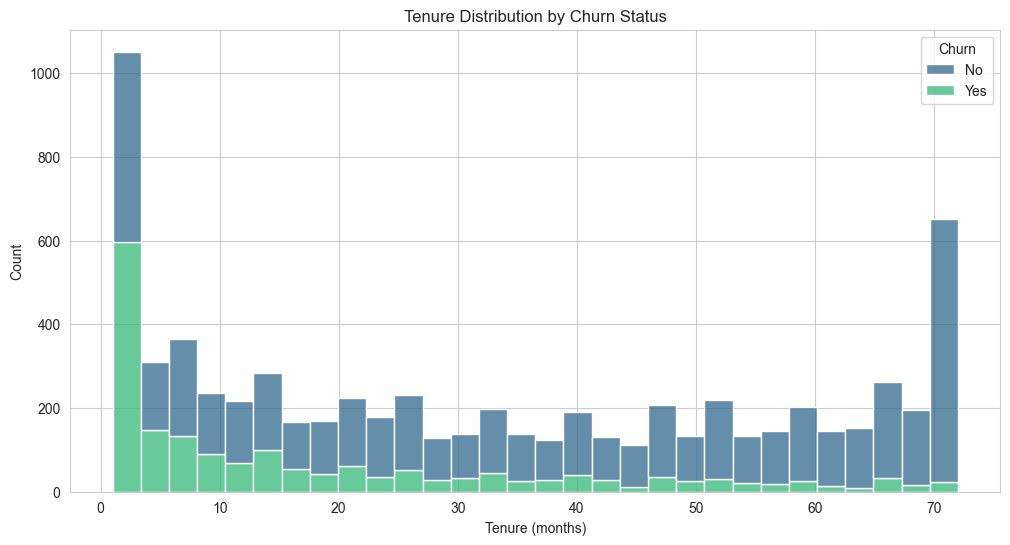

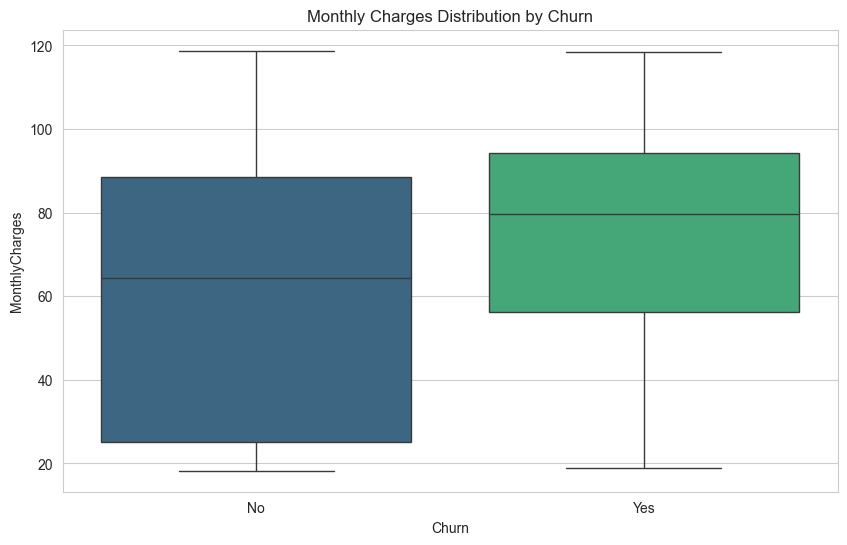

In [ ]:
#KEY VISUALIZATIONS - EDA
important_categorical = [
    'Contract', 'InternetService', 'TechSupport', 'OnlineSecurity',
    'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents'
]

for col in important_categorical:
    plt.figure(figsize=(12,6))
    sns.countplot(x=col, hue='Churn', data=df, palette='viridis')
    plt.title(f'Churn Rate by {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Numeric features vs Churn
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, palette='viridis')
plt.title('Tenure Distribution by Churn Status')
plt.xlabel('Tenure (months)')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='viridis')
plt.title('Monthly Charges Distribution by Churn')
plt.show()

# Correlation Matrix for Numeric Features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
df_numeric = df[numeric_cols + ['Churn']].copy()
df_numeric['Churn'] = df_numeric['Churn'].map({'Yes': 1, 'No': 0})

plt.figure(figsize=(10, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

# these plots show the strongest patterns: month-to-month contracts, fiber optic, no support → much higher churn


In [46]:
# Advanced Feature Engineering
df['tenure_monthly_interaction'] = df['tenure'] * df['MonthlyCharges']
df['tenure_bin'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=[0,1,2,3])  # 0=new, 3=long-term
df['monthly_bin'] = pd.cut(df['MonthlyCharges'], bins=[0,50,75,100,120], labels=[0,1,2,3])  # 0=low, 3=high

In [47]:
# 6. DATA PREPROCESSING FOR MODELING

In [48]:
# Step 6.1: Encode target (Yes/No → 1/0)
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

In [49]:
# Step 6.2: One-hot encoding for all categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)  # drop_first avoids multicollinearity


In [50]:
# Step 6.3: Separate features (X) and target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
# 🔹 SAVE FEATURE NAMES USED DURING TRAINING this is by chat gbt
feature_names = X.columns.tolist()


In [54]:
# Step 6.4: Train-Test Split (80/20, stratified to keep class balance)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5625, 37)
Test set shape: (1407, 37)


7. MODEL 1 - BASELINE: LOGISTIC REGRESSION

In [ ]:
logreg = LogisticRegression(max_iter=2000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)
y_prob_log = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression (Baseline) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_log), 4))
print(classification_report(y_test, y_pred_log))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


=== Logistic Regression (Baseline) ===
ROC-AUC: 0.8352
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



8. MODEL 2 - ADVANCED: XGBOOST

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Extended hyperparameter search for XGBoost
params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
} 

print("Starting GridSearchCV for XGBoost (this may take a few minutes)...")
grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'), 
    params, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
) 
grid.fit(X_train, y_train) 
xgb_tuned = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
# Use the tuned model from GridSearchCV
xgb = xgb_tuned

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost (Tuned Model) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_xgb), 4))
print(classification_report(y_test, y_pred_xgb))

# Feature importance visualization
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 15 XGBoost Feature Importance', fontsize=14)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


=== XGBoost (Advanced Model) ===
ROC-AUC: 0.8225
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



9. MODEL 3 - NEURAL NETWORK (Third Model Family)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # Two hidden layers for complexity
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

print("\n=== Neural Network (MLP) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_mlp), 4))
print(classification_report(y_test, y_pred_mlp))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Neural Network (MLP) - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


=== Neural Network (MLP) ===
ROC-AUC: 0.8116
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1033
           1       0.50      0.76      0.60       374

    accuracy                           0.73      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.73      0.75      1407



10 .COMPARISION TABLE 

In [ ]:
# Comprehensive Model Comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Neural Network (MLP)'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_mlp)],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_mlp)],
    'Precision': [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_mlp)],
    'Recall': [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_mlp)],
    'F1-Score': [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_mlp)]
})

print("\n=== Comprehensive Model Comparison ===")
print(results.round(4))

# Cross-Validation Scores
print("\n=== Cross-Validation Scores (5-fold) ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_log = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='roc_auc')
cv_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='roc_auc')
cv_mlp = cross_val_score(mlp, X_train, y_train, cv=cv, scoring='roc_auc')

cv_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Neural Network (MLP)'],
    'CV Mean ROC-AUC': [cv_log.mean(), cv_xgb.mean(), cv_mlp.mean()],
    'CV Std ROC-AUC': [cv_log.std(), cv_xgb.std(), cv_mlp.std()]
})
print(cv_results.round(4))

# ROC Curves
plt.figure(figsize=(10, 8))
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_score(y_test, y_prob_mlp):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(10, 8))
precision_log, recall_log, _ = precision_recall_curve(y_test, y_prob_log)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, y_prob_mlp)

plt.plot(recall_log, precision_log, label='Logistic Regression')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.plot(recall_mlp, precision_mlp, label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Model Comparison:
                  Model  ROC-AUC
0   Logistic Regression   0.8352
1               XGBoost   0.8225
2  Neural Network (MLP)   0.8116


11. SAVE THE BEST MODEL FOR DAY 2 (APP + SHAP)

In [ ]:
# Determine best model based on ROC-AUC
model_scores = {
    'Logistic Regression': roc_auc_score(y_test, y_prob_log),
    'XGBoost': roc_auc_score(y_test, y_prob_xgb),
    'MLP': roc_auc_score(y_test, y_prob_mlp)
}

best_model_name = max(model_scores, key=model_scores.get)
best_score = model_scores[best_model_name]

print(f"\nBest Model: {best_model_name} (ROC-AUC: {best_score:.4f})")

# Save the best model
if best_model_name == 'Logistic Regression':
    best_model = logreg
elif best_model_name == 'XGBoost':
    best_model = xgb
else:
    best_model = mlp

# Ensure app directory exists
os.makedirs('../app', exist_ok=True)

# Save best model and encoder
joblib.dump(best_model, '../app/best_model.pkl')
joblib.dump(le, '../app/target_encoder.pkl')

# Save feature names for app use
joblib.dump(X.columns.tolist(), '../app/feature_names.pkl')

print(f"\nBest model ({best_model_name}) saved to ../app/best_model.pkl")
print("Target encoder saved to ../app/target_encoder.pkl")
print("Feature names saved to ../app/feature_names.pkl")


Best model saved.
